# Is it a stone monument? 🗽

In [39]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception

## Step 1: Download images of stones and stone monuments

In [40]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a photo of a stone and seeing what kind of result we get. We'll start by getting URLs from a search:

In [72]:
urls = search_images('raw stones photo', max_images=1)
urls[0]

Searching for 'raw stones photo'


'https://i.etsystatic.com/22177135/r/il/bf7bc0/2783100524/il_fullxfull.2783100524_7q9i.jpg'

...and then download a URL and take a look at it:

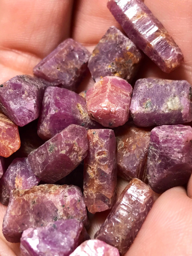

In [76]:
from fastdownload import download_url
dest = 'raw_stones.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "stone monument photos":

Searching for 'stone monument photo'


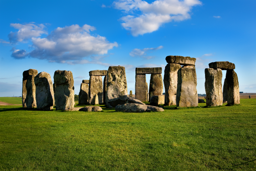

In [75]:
download_url(search_images('stone monument photo', max_images=1)[0], 'stone_monument.jpg', show_progress=False)
Image.open('stone_monument.jpg').to_thumb(256,256)  

Searches seem to be giving reasonable results, so let's grab a few examples of each of "stone" and "stone monument" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [77]:
searches = 'stone monument', 'raw stones'
path = Path('stone_monument_or_not')
from time import sleep

for search in searches:
    dest = (path/search)
    dest.mkdir(parents=True, exist_ok=True)
    download_images(dest, urls=search_images(f'{search} photo'))
    sleep(10) # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{search} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{search} shade photo'))
    sleep(10)
    resize_images(path/search, max_size=400, dest=path/search)

Searching for 'stone monument photo'
Searching for 'stone monument sun photo'
Searching for 'stone monument shade photo'
Searching for 'raw stones photo'
Searching for 'raw stones sun photo'
Searching for 'raw stones shade photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [78]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:

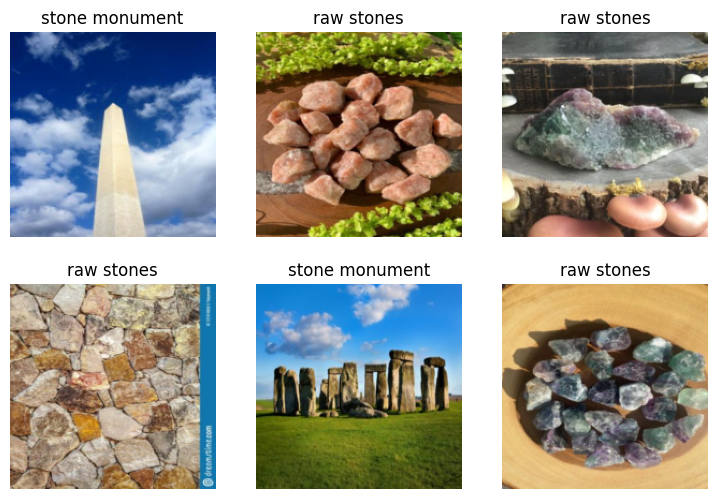

In [79]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now we're ready to train our model. The fastest widely used computer vision model is resnet18. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [83]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.843504,0.197966,0.057143,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.099797,0.126684,0.028571,00:08
1,0.069565,0.121283,0.028571,00:08
2,0.047604,0.150246,0.028571,00:08
3,0.035045,0.187558,0.028571,00:08
4,0.027146,0.205674,0.028571,00:08


## Step 3: Use our model

Let's see what our model thinks about that stone monument we downloaded at the start:

In [88]:
is_monument,_,probs = learn.predict(PILImage.create('stone_monument.jpg'))
print(f"This is a: {is_monument}.")
print(f"Probability it's a monument: {probs[1]:.4f}")

This is a: stone monument.
Probability it's a monument: 1.0000


Awesome, resnet18. :)